# Engenharia de Atributos

In [1]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [2]:
import pandas as pd

nome_arquivo = f'2.atributos.parquet'
df = pd.read_parquet(nome_arquivo)
df = df[:100000]

2025-05-30 13:43:32 - INFO - NumExpr defaulting to 8 threads.


In [3]:
df.head(5)

,regiao,estado,municipio,coduf,codmun,cod_regiao_saude,nome_regiao_saude,data,semana_epi,populacao_tcu_2019,...,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,novos_casos_acumulados,mes,mes_traduzido,dia_semana,dia_semana_traduzido,estacao
0,Centro-Oeste,GO,Abadia de Goiás,52,520005.0,52001.0,CENTRAL,2020-03-27,13,8773.0,...,0,0,1.0,0,0,March,Março,Friday,Sexta-feira,Outono
1,Centro-Oeste,GO,Abadia de Goiás,52,520005.0,52001.0,CENTRAL,2020-03-28,13,8773.0,...,0,0,1.0,0,0,March,Março,Saturday,Sábado,Outono
2,Centro-Oeste,GO,Abadia de Goiás,52,520005.0,52001.0,CENTRAL,2020-03-29,14,8773.0,...,0,0,1.0,0,0,March,Março,Sunday,Domingo,Outono
3,Centro-Oeste,GO,Abadia de Goiás,52,520005.0,52001.0,CENTRAL,2020-03-30,14,8773.0,...,0,0,1.0,0,0,March,Março,Monday,Segunda-feira,Outono
4,Centro-Oeste,GO,Abadia de Goiás,52,520005.0,52001.0,CENTRAL,2020-03-31,14,8773.0,...,0,0,1.0,0,0,March,Março,Tuesday,Terça-feira,Outono


In [4]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
le = LabelEncoder()

# Columns to encode
cols_to_encode = ['regiao', 'estado', 'municipio', 'nome_regiao_saude', 'estacao']

# Apply label encoding to each column
for col in cols_to_encode:
    df[col] = le.fit_transform(df[col])

In [5]:
df.head(5)

,regiao,estado,municipio,coduf,codmun,cod_regiao_saude,nome_regiao_saude,data,semana_epi,populacao_tcu_2019,...,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,novos_casos_acumulados,mes,mes_traduzido,dia_semana,dia_semana_traduzido,estacao
0,0,4,0,52,520005.0,52001.0,23,2020-03-27,13,8773.0,...,0,0,1.0,0,0,March,Março,Friday,Sexta-feira,1
1,0,4,0,52,520005.0,52001.0,23,2020-03-28,13,8773.0,...,0,0,1.0,0,0,March,Março,Saturday,Sábado,1
2,0,4,0,52,520005.0,52001.0,23,2020-03-29,14,8773.0,...,0,0,1.0,0,0,March,Março,Sunday,Domingo,1
3,0,4,0,52,520005.0,52001.0,23,2020-03-30,14,8773.0,...,0,0,1.0,0,0,March,Março,Monday,Segunda-feira,1
4,0,4,0,52,520005.0,52001.0,23,2020-03-31,14,8773.0,...,0,0,1.0,0,0,March,Março,Tuesday,Terça-feira,1


In [6]:
df = df.drop(columns=['mes', 'mes_traduzido', 'dia_semana', 'dia_semana_traduzido', 'casos_novos', 'casos_acumulados', 'coduf', 'codmun', 'cod_regiao_saude', 'nome_regiao_saude'])

<Axes: >

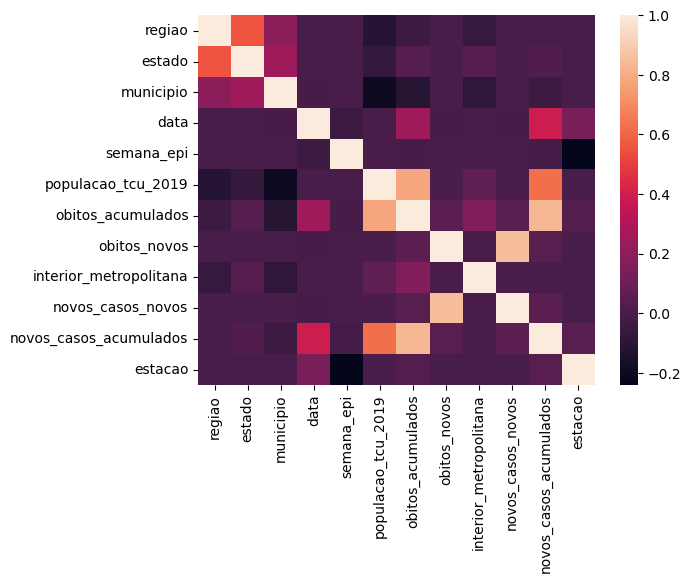

In [8]:
from seaborn import heatmap

heatmap(df.corr())

In [9]:
def _adicionar_lag_features(df):
    df["novos_casos_novos_lag_1"] = df['novos_casos_novos'].shift(1)
    df["obitos_novos_lag_1"] = df['obitos_novos'].shift(1)

    df["novos_casos_novos_lag_7"] = df['novos_casos_novos'].shift(7)
    df["obitos_novos_lag_7"] = df['obitos_novos'].shift(7)

    df["novos_casos_novos_lag_14"] = df['novos_casos_novos'].shift(14)
    df["obitos_novos_lag_14"] = df['obitos_novos'].shift(14)

    return df

def _adicionar_media_movel_7(df):
    df['novos_casos_novos_media_movel_7'] = df['novos_casos_novos'].transform(lambda x: x.shift(1).rolling(7).mean())
    df['obitos_novos_media_movel_7'] = df['obitos_novos'].transform(lambda x: x.shift(1).rolling(7).mean())

    return df

In [10]:
def _rodar_engenharia_de_atributos(df):
    df = _adicionar_lag_features(df)
    df = _adicionar_media_movel_7(df)

    return df

In [11]:
from tqdm import tqdm

def _processar(df):
    logging.info("Processando municipios_unicos")
    municipios_unicos = set(zip(df['municipio'], df['estado']))
    logging.info("Processamento concluído")

    logging.info("Filtrando o dataframe ")
    mascara = df.apply(lambda x: (
        x['municipio'], x['estado']) in municipios_unicos, axis=1)
    filtrado_df = df[mascara]
    logging.info("Processamento concluído")

    logging.info("Processando grupos")
    agrupado = filtrado_df.groupby(['municipio', 'estado'])
    logging.info("Processamento concluído")

    resultado_df = []

    for (municipio, estado), group_df in tqdm(agrupado, desc="Processando"):
        try:
            group_df = group_df.sort_values(by='data')
            resultado_df.append(_rodar_engenharia_de_atributos(group_df))
        except Exception as e:
            logging.error(f"{estado}_{municipio} não foi salvo")
            logging.error(e)

    resultado_df = pd.concat(resultado_df)
    return resultado_df

In [12]:
df = _processar(df)

2025-05-30 13:46:56 - INFO - Processando municipios_unicos
2025-05-30 13:46:56 - INFO - Processamento concluído
2025-05-30 13:46:56 - INFO - Filtrando o dataframe 
2025-05-30 13:47:00 - INFO - Processamento concluído
2025-05-30 13:47:00 - INFO - Processando grupos
2025-05-30 13:47:00 - INFO - Processamento concluído
Processando: 100%|██████████| 55/55 [00:02<00:00, 23.68it/s]


In [13]:
df.columns

Index(['regiao', 'estado', 'municipio', 'data', 'semana_epi',
       'populacao_tcu_2019', 'obitos_acumulados', 'obitos_novos',
       'interior_metropolitana', 'novos_casos_novos', 'novos_casos_acumulados',
       'estacao', 'novos_casos_novos_lag_1', 'obitos_novos_lag_1',
       'novos_casos_novos_lag_7', 'obitos_novos_lag_7',
       'novos_casos_novos_lag_14', 'obitos_novos_lag_14',
       'novos_casos_novos_media_movel_7', 'obitos_novos_media_movel_7'],
      dtype='object')

In [14]:
df.head(5)

,regiao,estado,municipio,data,semana_epi,populacao_tcu_2019,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,novos_casos_acumulados,estacao,novos_casos_novos_lag_1,obitos_novos_lag_1,novos_casos_novos_lag_7,obitos_novos_lag_7,novos_casos_novos_lag_14,obitos_novos_lag_14,novos_casos_novos_media_movel_7,obitos_novos_media_movel_7
0,0,4,0,2020-03-27,13,8773.0,0,0,1.0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,4,0,2020-03-28,13,8773.0,0,0,1.0,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,4,0,2020-03-29,14,8773.0,0,0,1.0,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,4,0,2020-03-30,14,8773.0,0,0,1.0,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,0,2020-03-31,14,8773.0,0,0,1.0,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


# XGBoost

In [15]:
from xgboost import XGBRegressor

def treinamento(df_treino, df_teste):
  X_treino, y_treino = df_treino[df_treino.columns.difference(['novos_casos_novos', 'data'])], df_treino[['novos_casos_novos']]
  X_teste = df_teste[df_teste.columns.difference(['novos_casos_novos', 'data'])]

  model = XGBRegressor()
  model.fit(X_treino, y_treino)

  coluna_predita = model.predict(X_teste)

  df_teste['predicao'] = coluna_predita

  return df_teste, model.feature_importances_


In [16]:
df_teste, feature_importances = treinamento(df.iloc[:-1], pd.DataFrame([df.iloc[-1]]))

df_teste.head(5)

,regiao,estado,municipio,data,semana_epi,populacao_tcu_2019,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,...,estacao,novos_casos_novos_lag_1,obitos_novos_lag_1,novos_casos_novos_lag_7,obitos_novos_lag_7,novos_casos_novos_lag_14,obitos_novos_lag_14,novos_casos_novos_media_movel_7,obitos_novos_media_movel_7,predicao
99999,3,6,54,2020-08-27,35,2674.0,0,0,0.0,4,...,0,4.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.0,0.525602


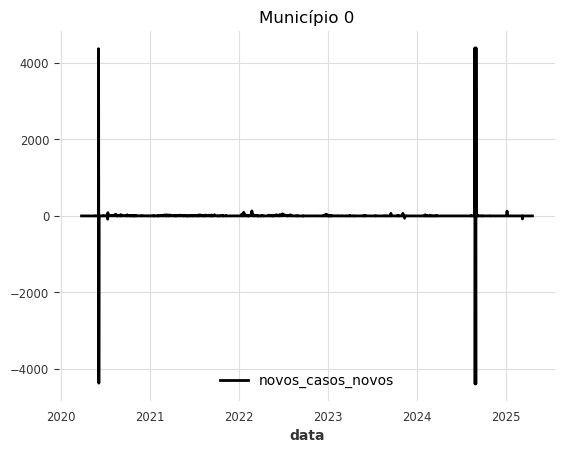

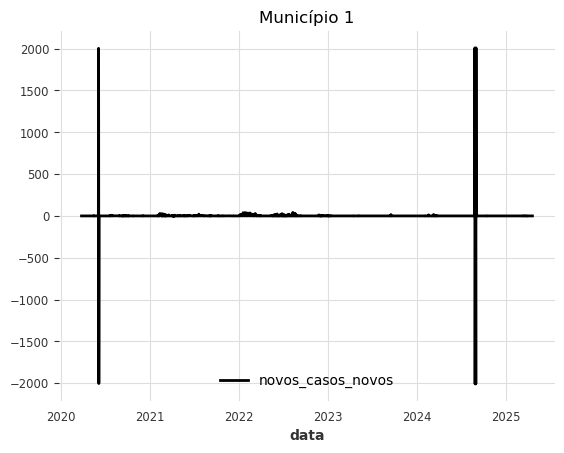

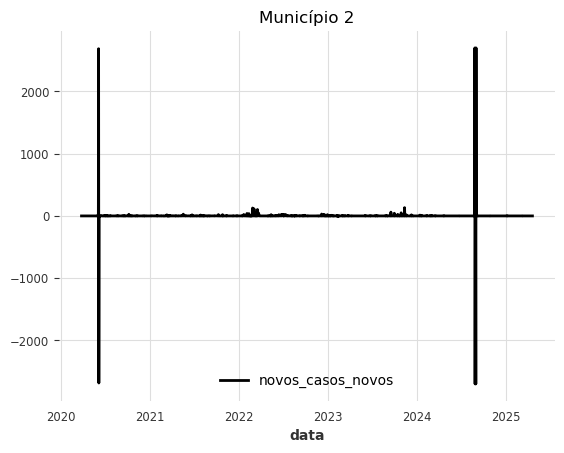

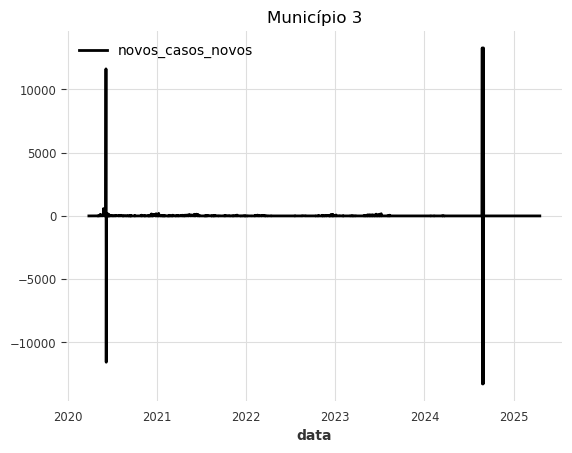

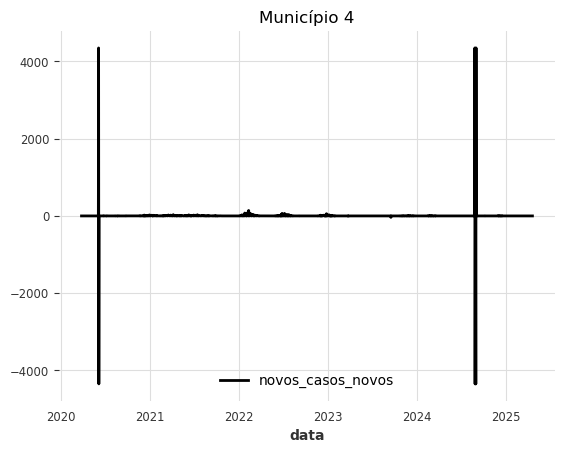

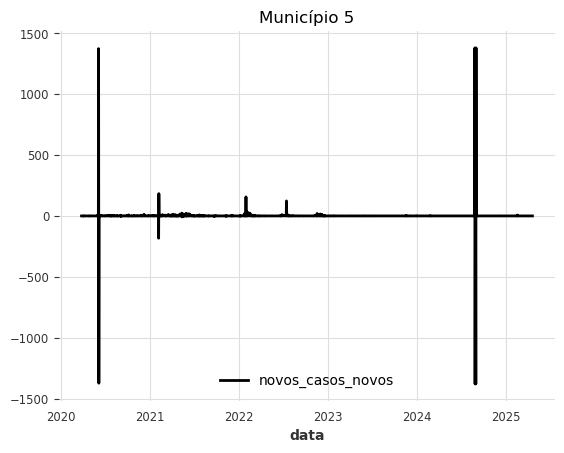

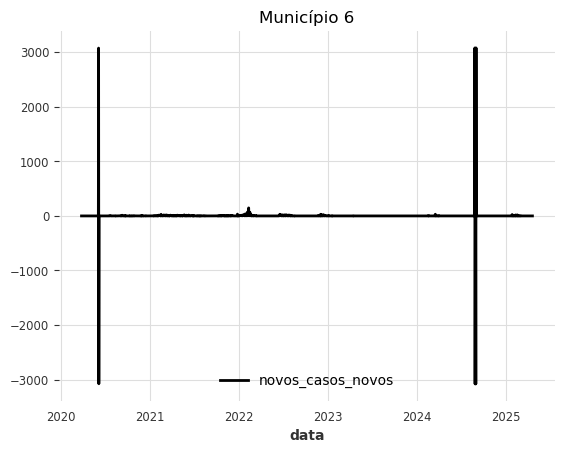

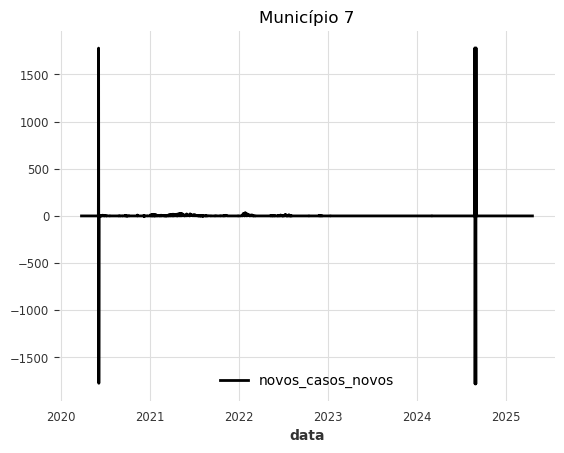

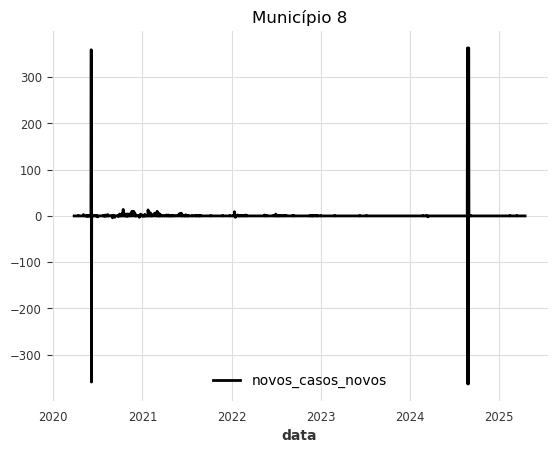

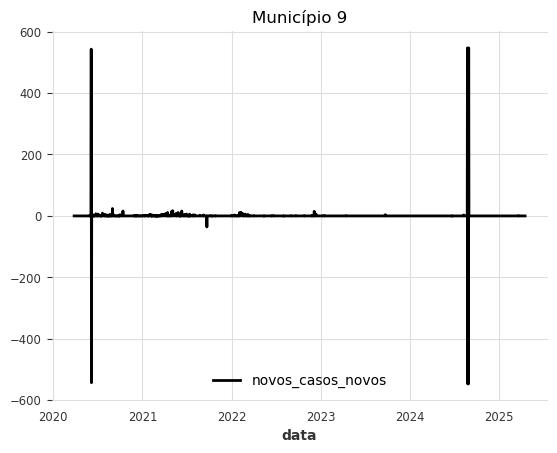

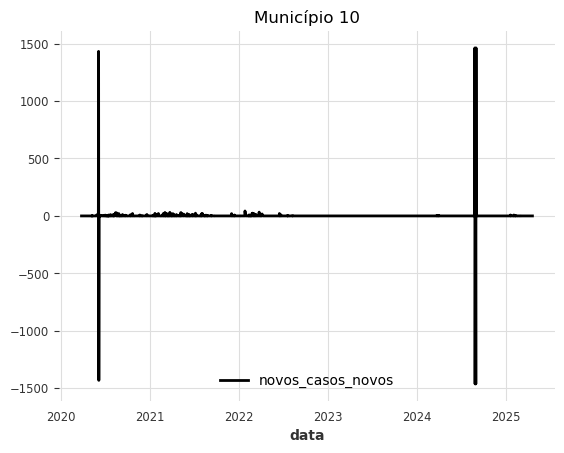

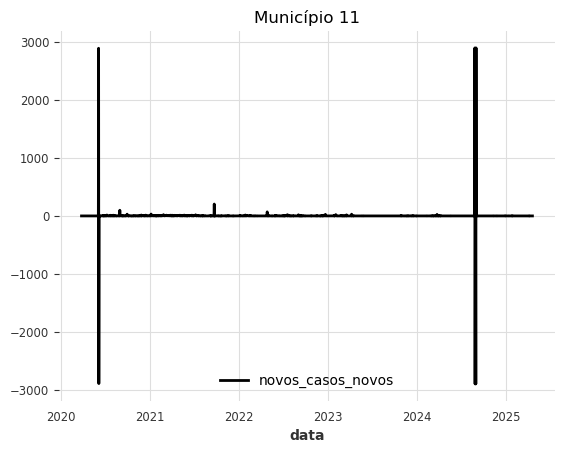

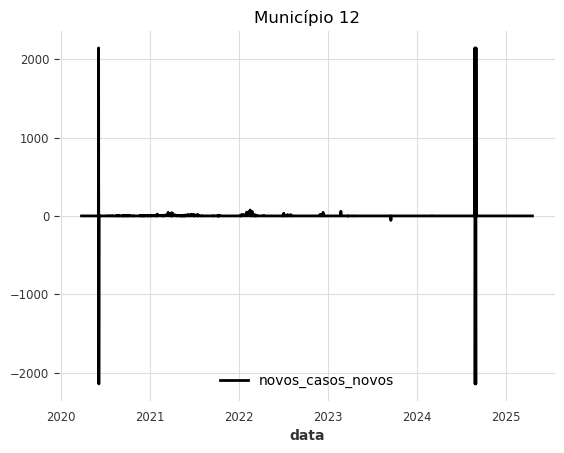

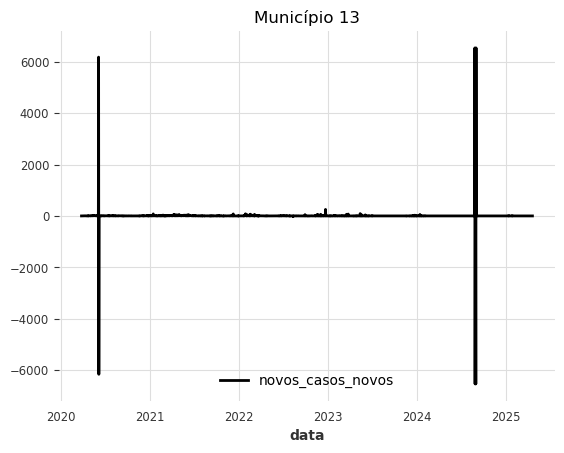

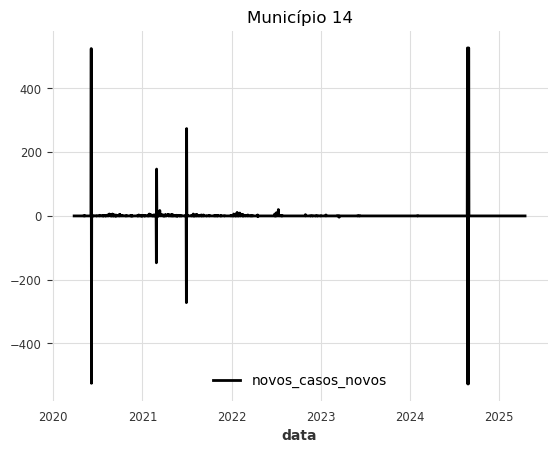

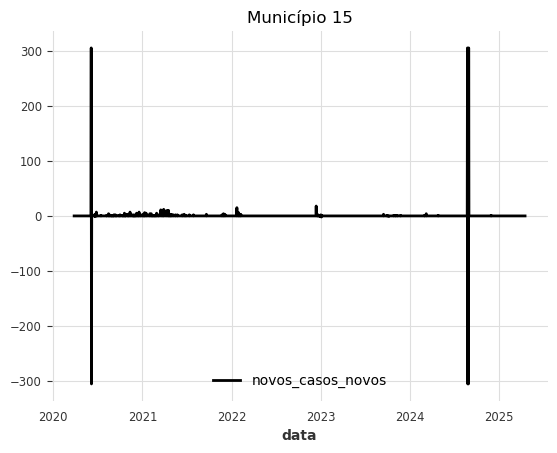

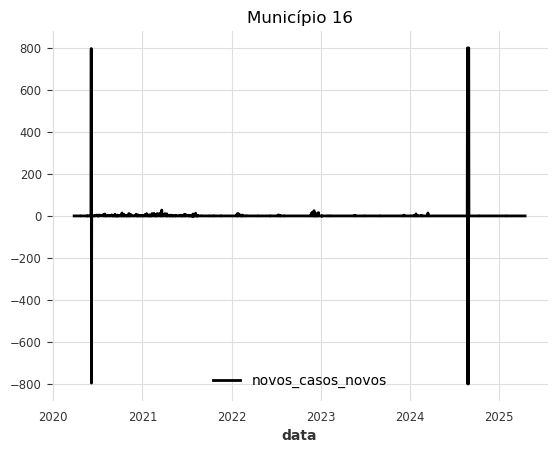

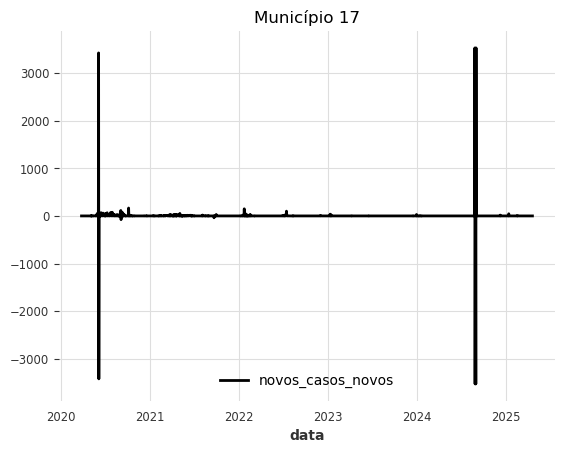

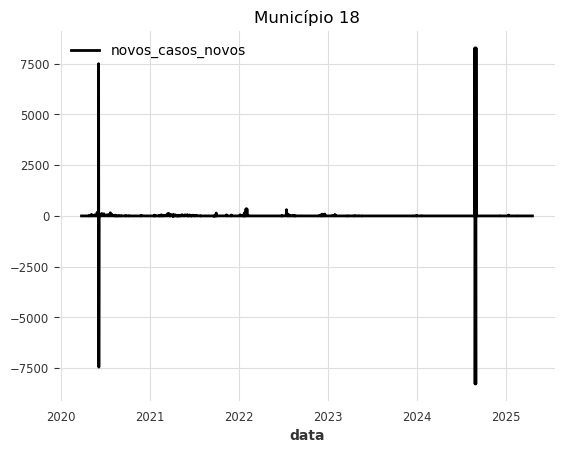

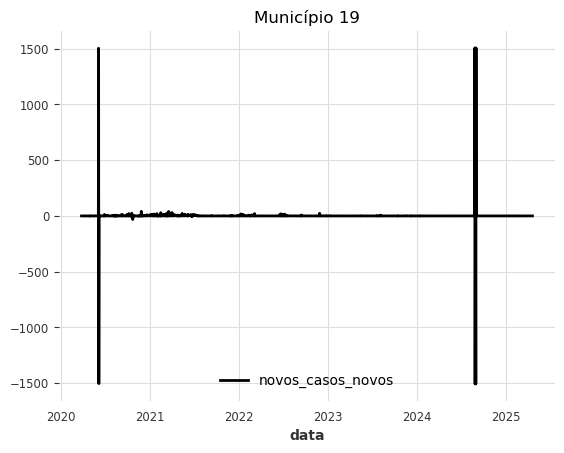

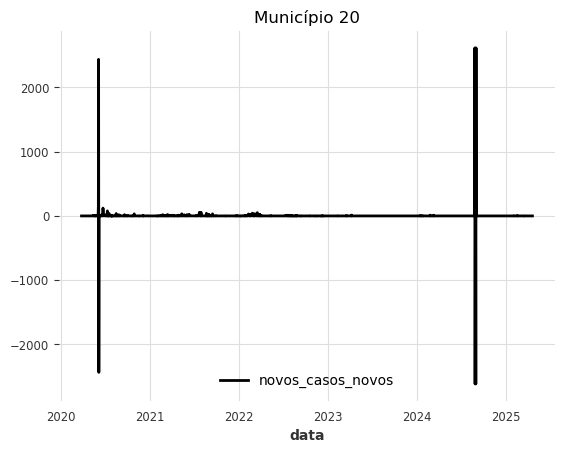

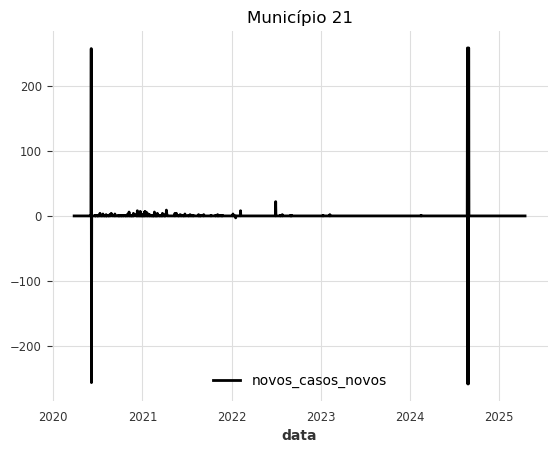

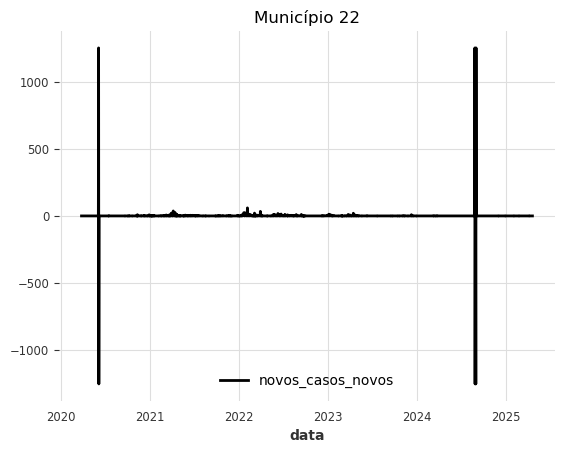

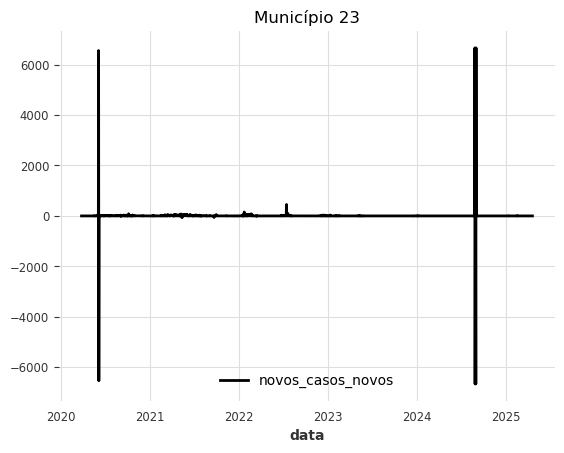

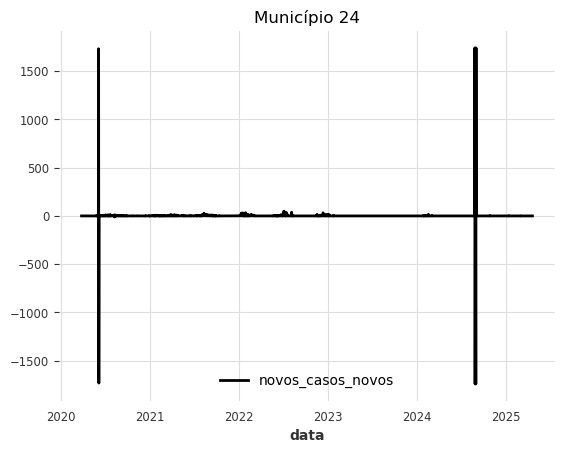

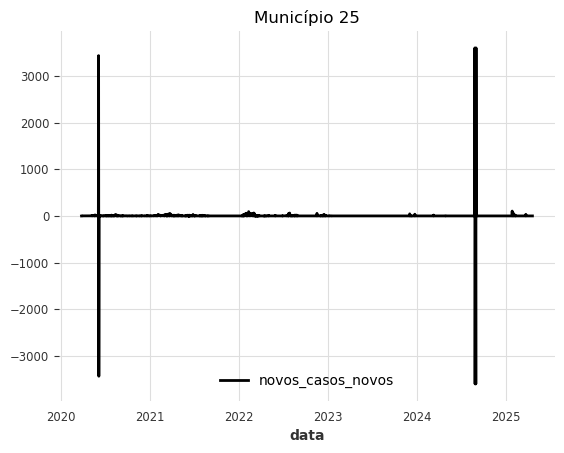

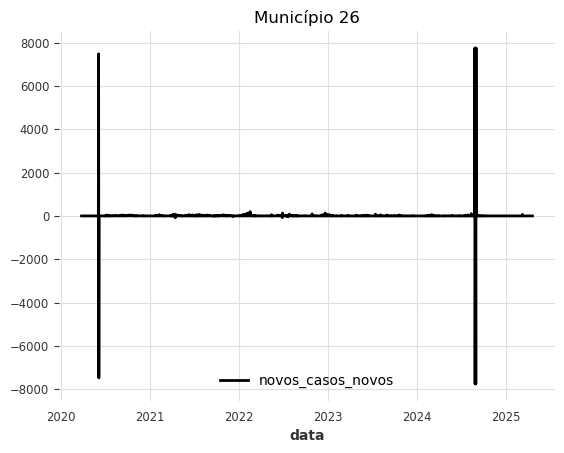

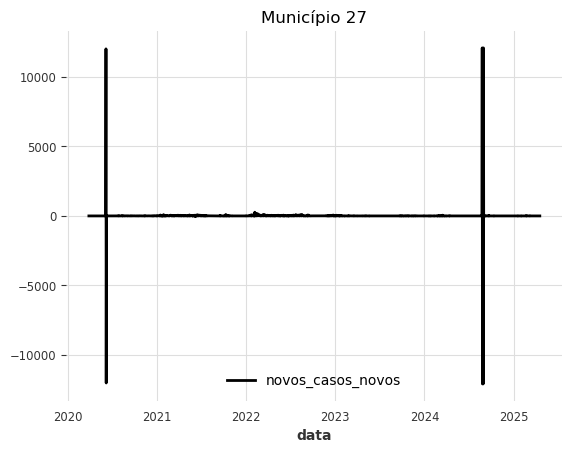

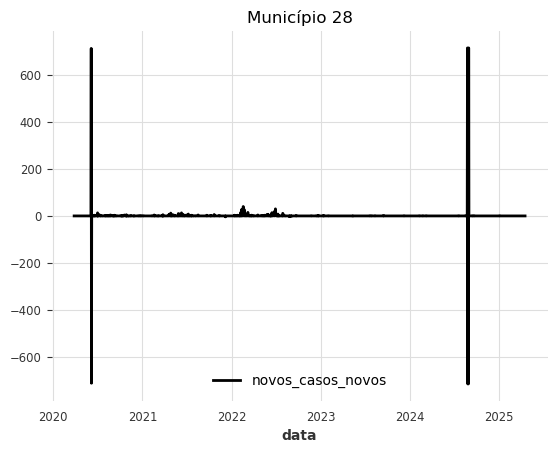

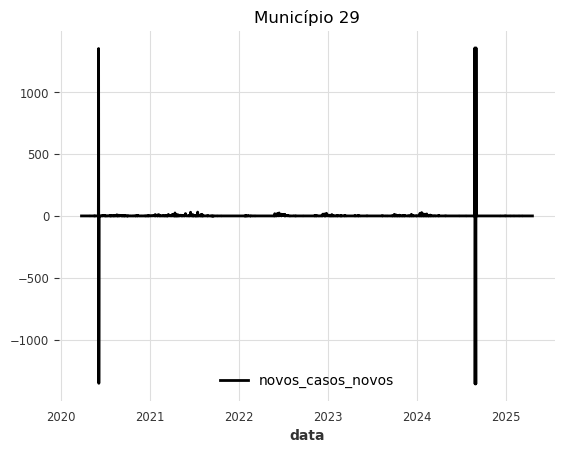

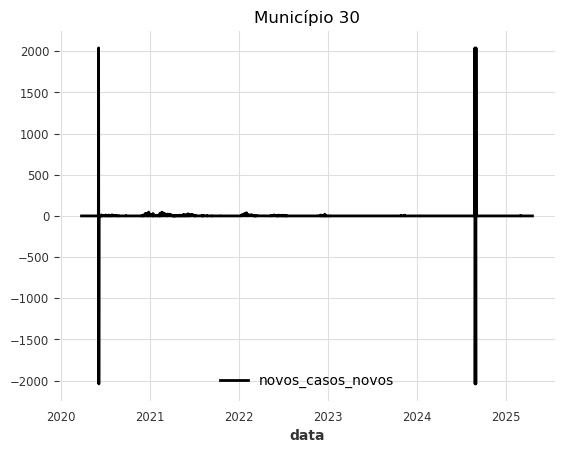

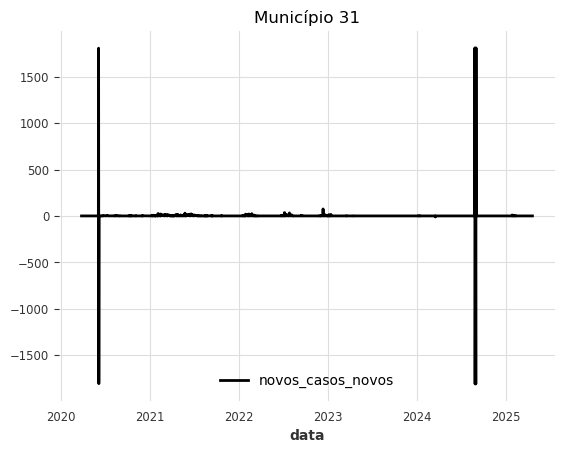

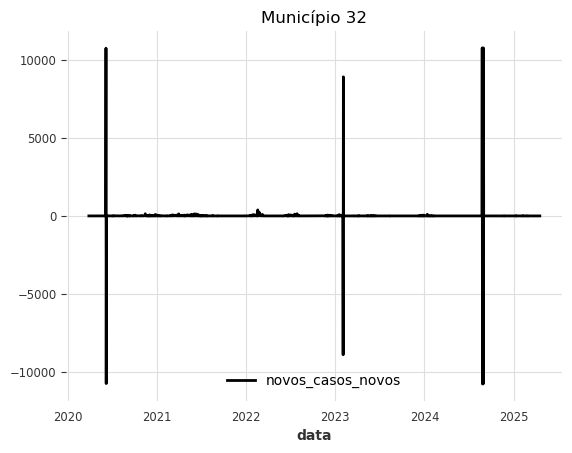

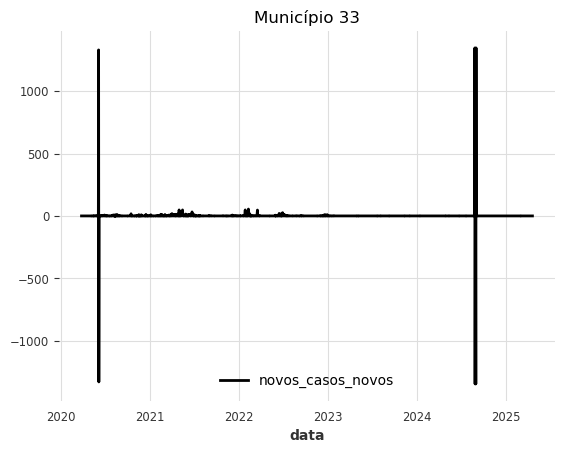

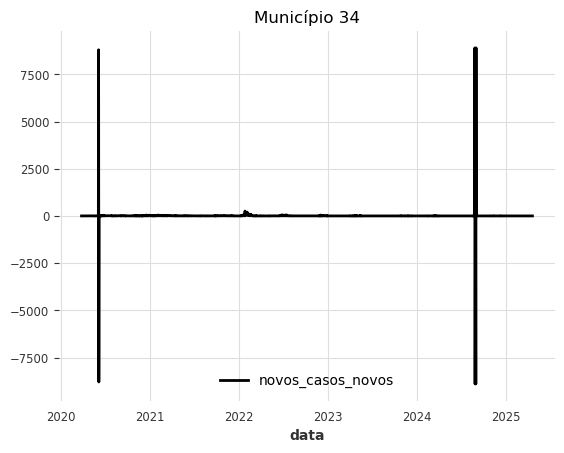

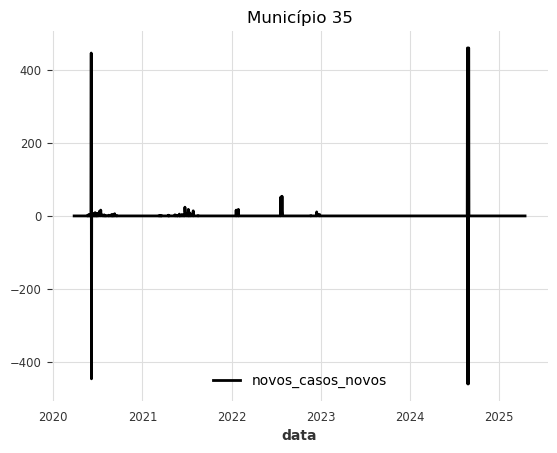

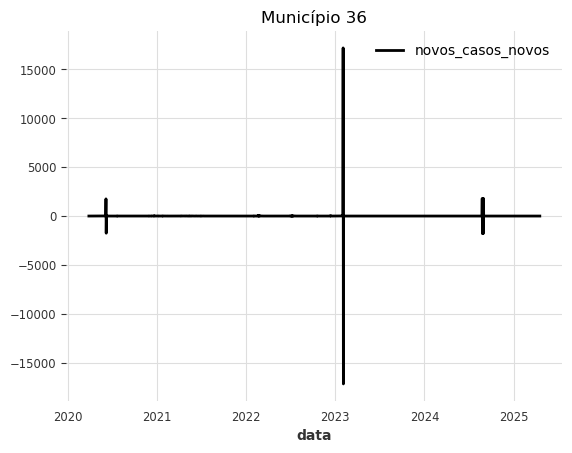

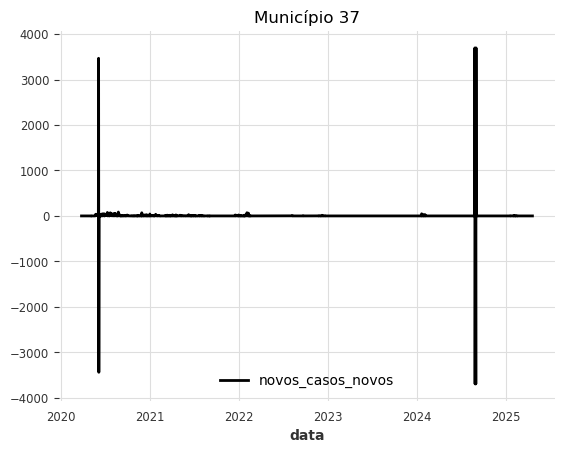

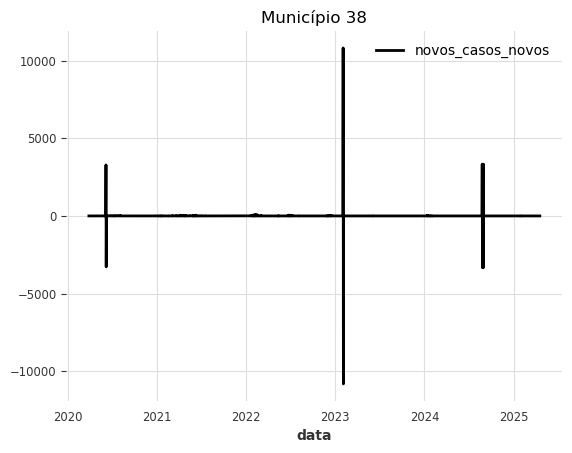

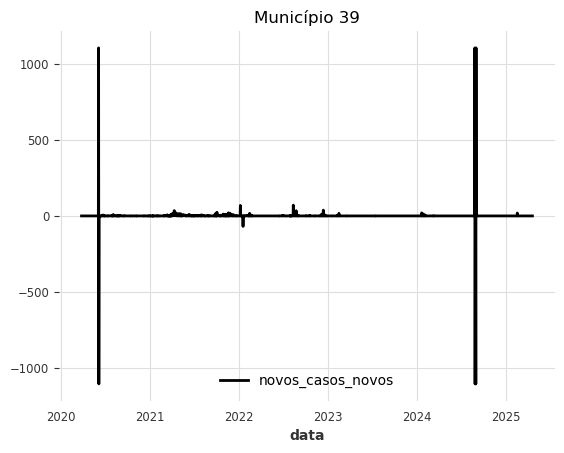

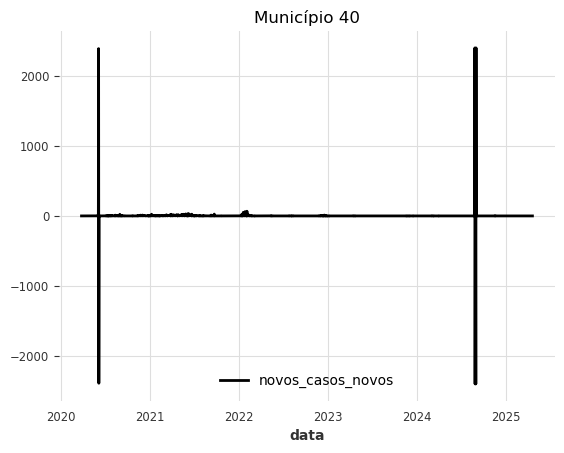

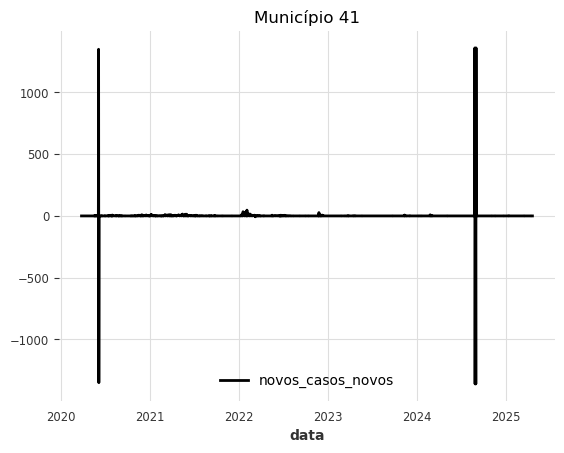

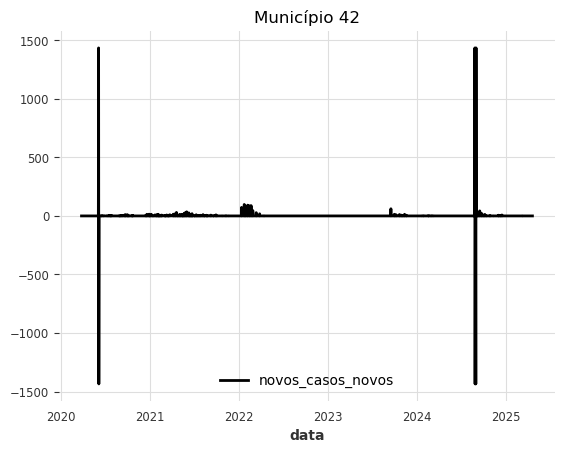

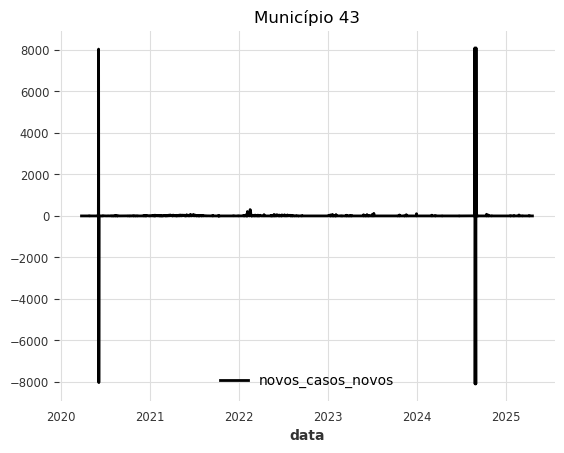

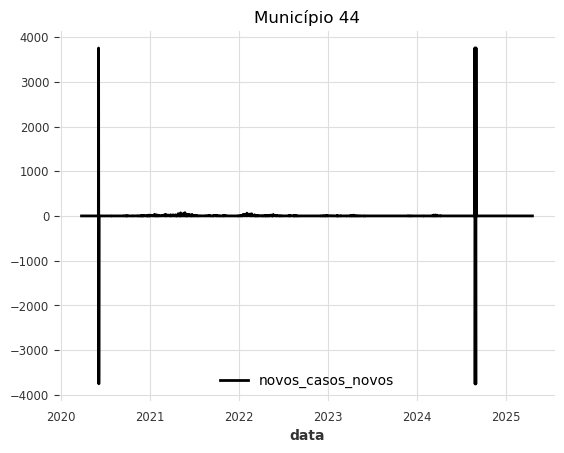

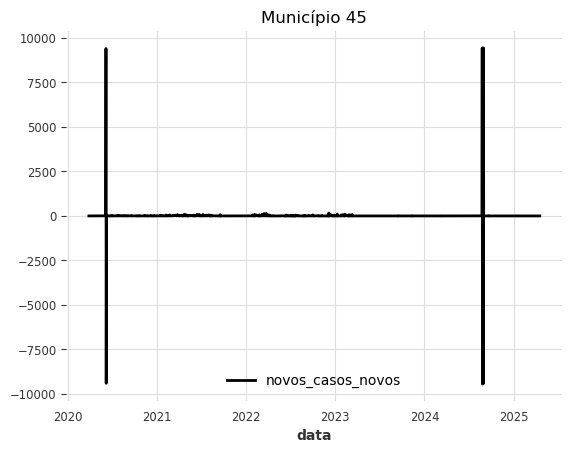

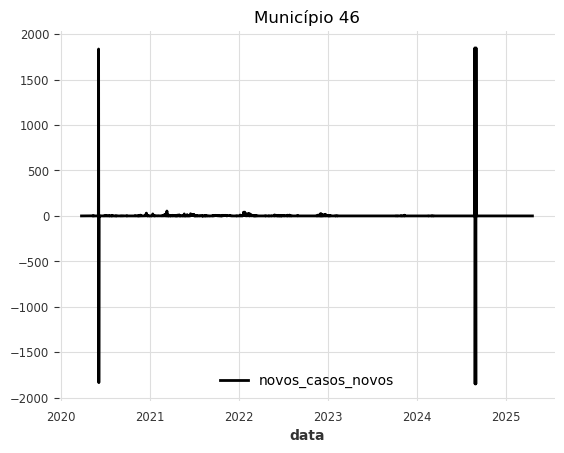

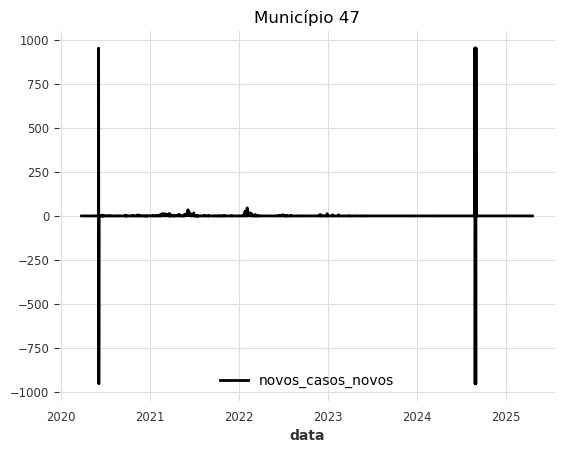

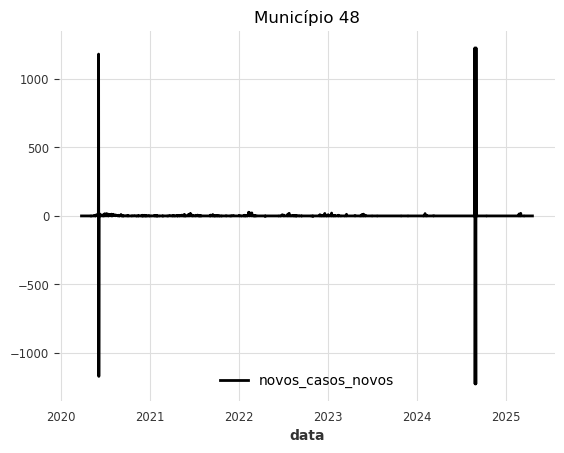

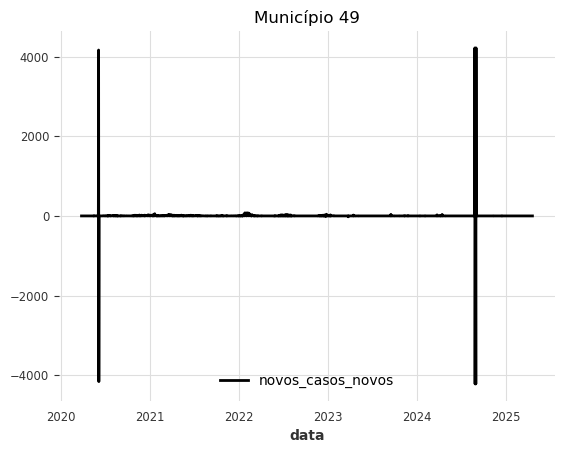

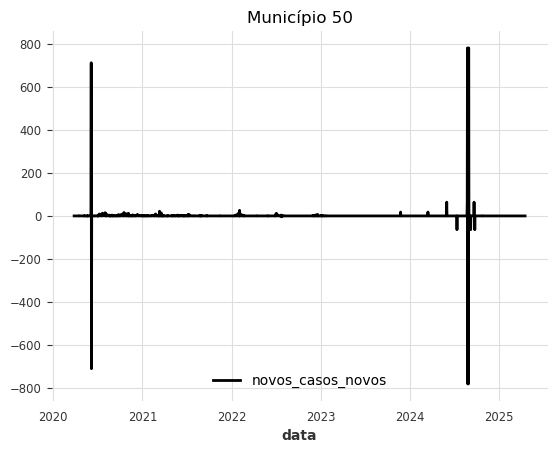

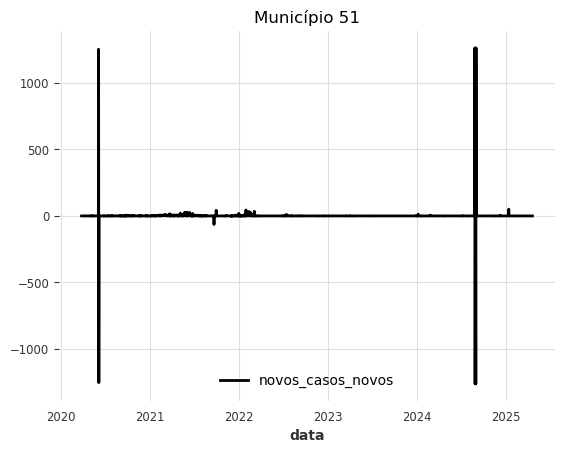

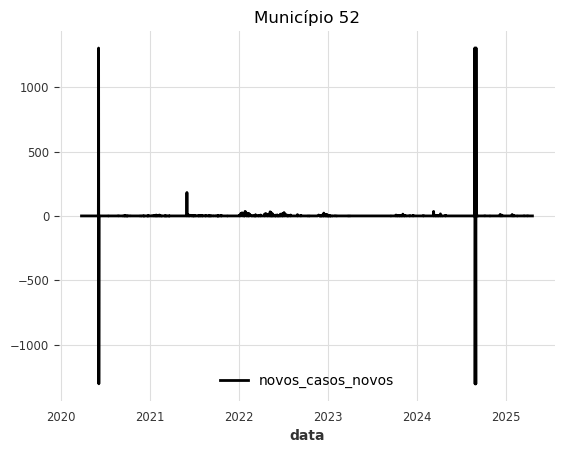

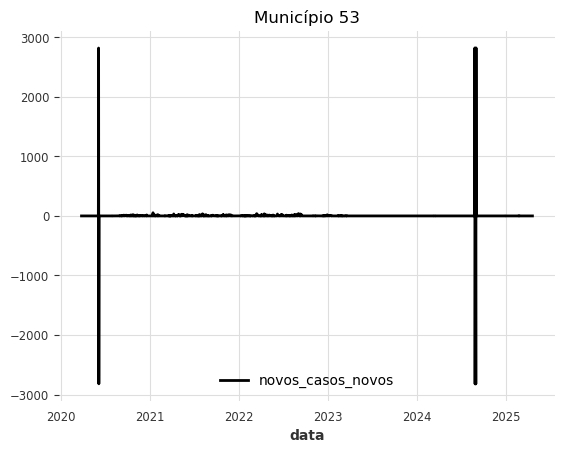

In [40]:
from darts import TimeSeries
import matplotlib.pyplot as plt

for i in range(54):
    df_municipio = df[df['municipio'] == i]
    series = TimeSeries.from_dataframe(df_municipio[['data', 'novos_casos_novos']], time_col="data", freq="D")
    series.plot()
    plt.title(f"Município {i}")
    plt.show()

<Axes: xlabel='data'>

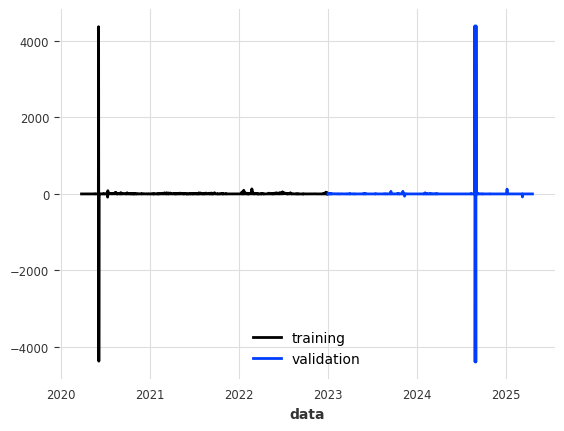

In [ ]:
train, val = series.split_before(pd.Timestamp("20230101")) # series.split_after(0.75)
train.plot(label="training")
val.plot(label="validation")